In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_info(filename):
    
    info = {}

    with open(filename, "r") as file:
        for line in file:

            if "=" in line:
                key, value = line.split("=")
                key = key.strip()     # remove whitespace
                value = value.strip() # remove whitespace

                try:
                    if "." in value:
                        value = float(value)

                    else:
                        value = int(value)

                except ValueError:
                    pass # leave the value as a string

                info[key] = value
                
    return info

In [3]:
def read_header(file):
    """
    Reads a padded value from a binary file.
    Each block contains [header_size][value][tail_size].
    """
    header_size = struct.unpack('i', file.read(4))[0]
    
    if   header_size ==  4: value = struct.unpack('i', file.read(header_size))[0]
    elif header_size ==  8: value = struct.unpack('q', file.read(header_size))[0]
    elif header_size == 16: value = struct.unpack('4i', file.read(header_size))
    else:
        raise ValueError(f"Unexpected header size: {header_size} bytes")
    
    tail_size = struct.unpack('i', file.read(4))[0]
    
    if header_size != tail_size:
        raise ValueError(f"Size mismatch: header_size={header_size}, tail_size={tail_size}")
    
    return value

In [4]:
def read_data(file, npart, dtype=np.float64):
    header_size = struct.unpack('i', file.read(4))[0]
    data = np.fromfile(file, dtype=dtype, count=npart)
    tail_size = struct.unpack('i', file.read(4))[0]
    
    if header_size != tail_size:
        raise ValueError(f"Size mismatch: header_size={header_size}, tail_size={tail_size}")
    
    return data

In [5]:
def get_output(filename, fields=None):
    
    data = {}

    with open(filename, 'rb') as file:
        """
        output_part.f90:
        ! Write header
          write(ilun)ncpu
          write(ilun)ndim
          write(ilun)npart #per MPI rank
          write(ilun)localseed
          write(ilun)nstar_tot #in total box
          write(ilun)mstar_tot #in total box
          write(ilun)mstar_lost
          write(ilun)nsink # bh
        """

        # Read all header values
        ncpu = read_header(file)
        ndim = read_header(file)
        npart = read_header(file)
        localseed = read_header(file)
        nstar_tot = read_header(file)
        mstar_tot = read_header(file)
        mstar_lost = read_header(file)
        nsink = read_header(file)

        # Save header information
        data['header'] = {
            'ncpu': ncpu,
            'ndim': ndim,
            'npart': npart,
            'localseed': localseed,
            'nstar_tot': nstar_tot,
            'mstar_tot': mstar_tot,
            'mstar_lost': mstar_lost,
            'nsink': nsink
        }


        # Read data
        positions = np.zeros((npart, ndim))
        positions[:, 0] = read_data(file, npart, dtype=np.float64)
        positions[:, 1] = read_data(file, npart, dtype=np.float64)
        positions[:, 2] = read_data(file, npart, dtype=np.float64)
        data['positions'] = positions

        velocities = np.zeros((npart, ndim))
        velocities[:, 0] = read_data(file, npart, dtype=np.float64)
        velocities[:, 1] = read_data(file, npart, dtype=np.float64)
        velocities[:, 2] = read_data(file, npart, dtype=np.float64)
        data['velocities'] = velocities

        data['masses']  = read_data(file, npart, dtype=np.float64)
        data['ids']     = read_data(file, npart, dtype=np.int64)
        data['levels']  = read_data(file, npart, dtype=np.int32)
        data['phi']      = read_data(file, npart, dtype=np.float64)
        data['tc_birth'] = read_data(file, npart, dtype=np.float64)
        data['metal']    = read_data(file, npart, dtype=np.float64)
        data['tp_birth'] = read_data(file, npart, dtype=np.float64)
        data['masses0']  = read_data(file, npart, dtype=np.float64)
        data['indtab']   = read_data(file, npart, dtype=np.float64)

    # If specific fields are requested, filter data
    if fields:
        filtered_data = {field: data[field] for field in fields if field in data}
        return filtered_data
    
    return data


In [6]:
snapNum = 50
basePath = "./lmin07-hr5-32-01-grammar"
info = read_info(f"{basePath}/info_{snapNum:05d}.txt")

In [7]:
info

{'ncpu': 32,
 'ndim': 3,
 'levelmin': 7,
 'levelmax': 14,
 'ngridmax': 312500,
 'nstep_coarse': 1530,
 'boxlen': 1.0,
 'time': -2.12297303403662,
 'aexp': 0.351355407860425,
 'H0': 72.0,
 'omega_m': 0.259999990463257,
 'omega_l': 0.740000009536743,
 'omega_k': 0.0,
 'omega_b': 0.0469999983906746,
 'unit_l': 1.77303504094929e+25,
 'unit_d': 5.84192863273623e-29,
 'unit_t': 5.28094330151276e+16,
 'ordering type': 'hilbert'}

In [8]:
ncpu = info['ncpu']
ndim = info['ndim']
boxlen = info['boxlen']
unit_l = info['unit_l']
unit_d = info['unit_d']
unit_t = info['unit_t']

lmin = info['levelmin']
lmax = info['levelmin']
time = info['time']
aexp = info['aexp']

H0 = info['H0']
h = H0 / 100

In [9]:
npart_tot = 0

for icpu in range(1, ncpu+1):
    filename = f"./lmin07-hr5-32-01-grammar/part_{snapNum:05d}.out{icpu:05d}"
    data = get_output(filename, fields=['header'])
    npart_tot += data['header']['npart']

print(f"{npart_tot:,.0f}")

2,549,033


<IPython.core.display.Javascript object>


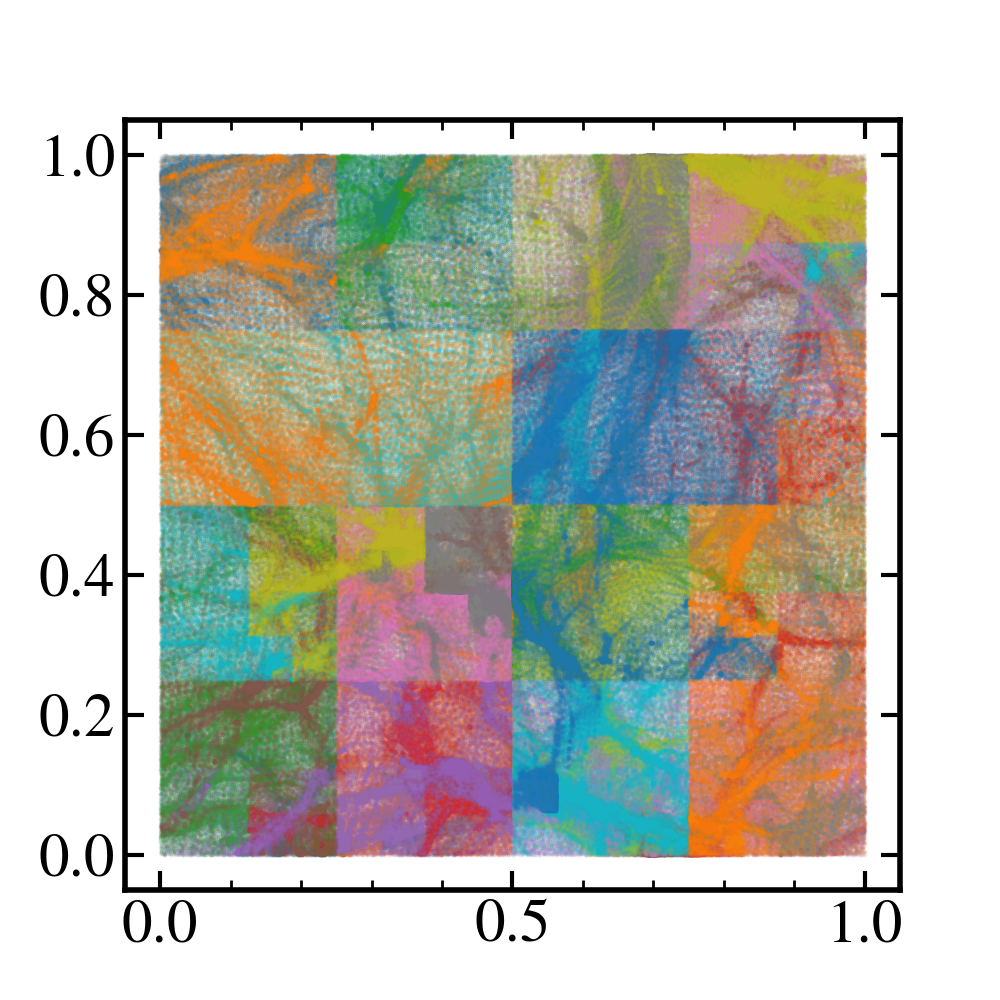

0 91384
91384 185627
185627 262710
262710 328081
328081 407043
407043 481251
481251 550783
550783 634879
634879 713270
713270 819490
819490 914346
914346 1017723
1017723 1088868
1088868 1182121
1182121 1233659
1233659 1299896
1299896 1385362
1385362 1457153
1457153 1541165
1541165 1601844
1601844 1666639
1666639 1738051
1738051 1813384
1813384 1899552
1899552 2003417
2003417 2124484
2124484 2205257
2205257 2281016
2281016 2341304
2341304 2413265
2413265 2492844
2492844 2549033


In [10]:
plt.figure(figsize=(5, 5))

pos  = np.zeros((npart_tot, ndim), dtype=np.float64)
vel  = np.zeros((npart_tot, ndim), dtype=np.float64)
npart = np.zeros(ncpu, dtype=np.int64)
tp_birth = np.zeros(npart_tot, dtype=np.float64)
tc_birth = np.zeros(npart_tot, dtype=np.float64)

for icpu in range(ncpu):
    filename = f"./lmin07-hr5-32-01-grammar/part_{snapNum:05d}.out{icpu+1:05d}"
    data = get_output(filename)
    
    npart[icpu] = data['header']['npart']
    
    plt.scatter(data['positions'][:, 0], data['positions'][:, 1], s=0.1, alpha=0.1)
        
    i = np.sum(npart[:icpu])
    j = np.sum(npart[:icpu+1])
    print(i, j)
    
    pos[i:j, 0] = data['positions'][:, 0]
    pos[i:j, 1] = data['positions'][:, 1]
    pos[i:j, 2] = data['positions'][:, 2]
    
    vel[i:j, 0] = data['velocities'][:, 0]
    vel[i:j, 1] = data['velocities'][:, 1]
    vel[i:j, 2] = data['velocities'][:, 2]
    
    tp_birth[i:j] = data['tp_birth']
    tc_birth[i:j] = data['tc_birth']

In [11]:
np.cumsum(npart)

array([  91384,  185627,  262710,  328081,  407043,  481251,  550783,
        634879,  713270,  819490,  914346, 1017723, 1088868, 1182121,
       1233659, 1299896, 1385362, 1457153, 1541165, 1601844, 1666639,
       1738051, 1813384, 1899552, 2003417, 2124484, 2205257, 2281016,
       2341304, 2413265, 2492844, 2549033])

<IPython.core.display.Javascript object>


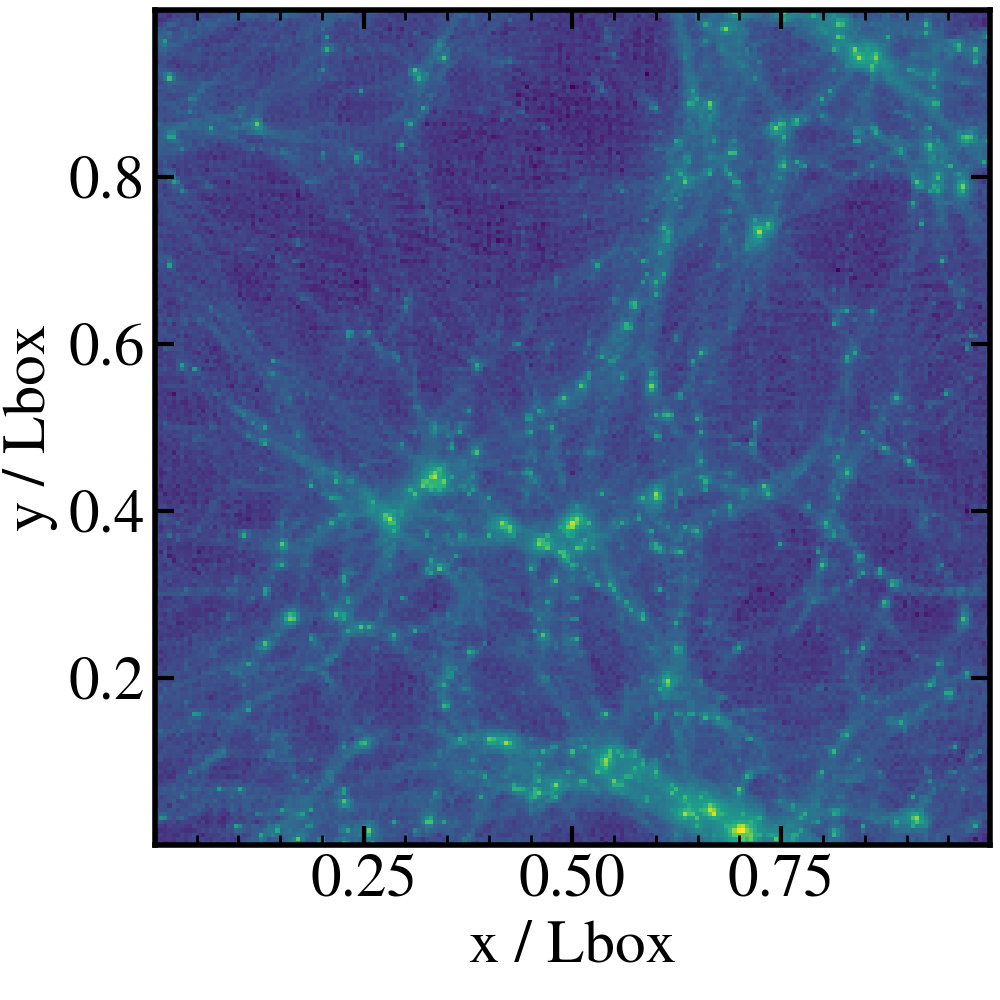

In [12]:
import matplotlib as mpl

plt.subplots(figsize=(5, 5))
# plt.scatter(pos[:, 0], pos[:, 1], s=0.1, c='k', alpha=0.1)
plt.hist2d(pos[:, 0], pos[:, 1], norm=mpl.colors.LogNorm(), bins=201)
plt.axis('equal')
plt.xlabel("x / Lbox")
plt.ylabel("y / Lbox")
plt.subplots_adjust(bottom=0.155, left=0.155, top=0.99, right=0.99)

In [13]:
npart_star = len(np.where(tp_birth<0)[0])
npart_dm   = npart_tot - npart_star

In [14]:
(2**lmin)**3

2097152

In [15]:
npart_star, npart_dm, (2**lmin)**3

(314386, 2234647, 2097152)

<IPython.core.display.Javascript object>


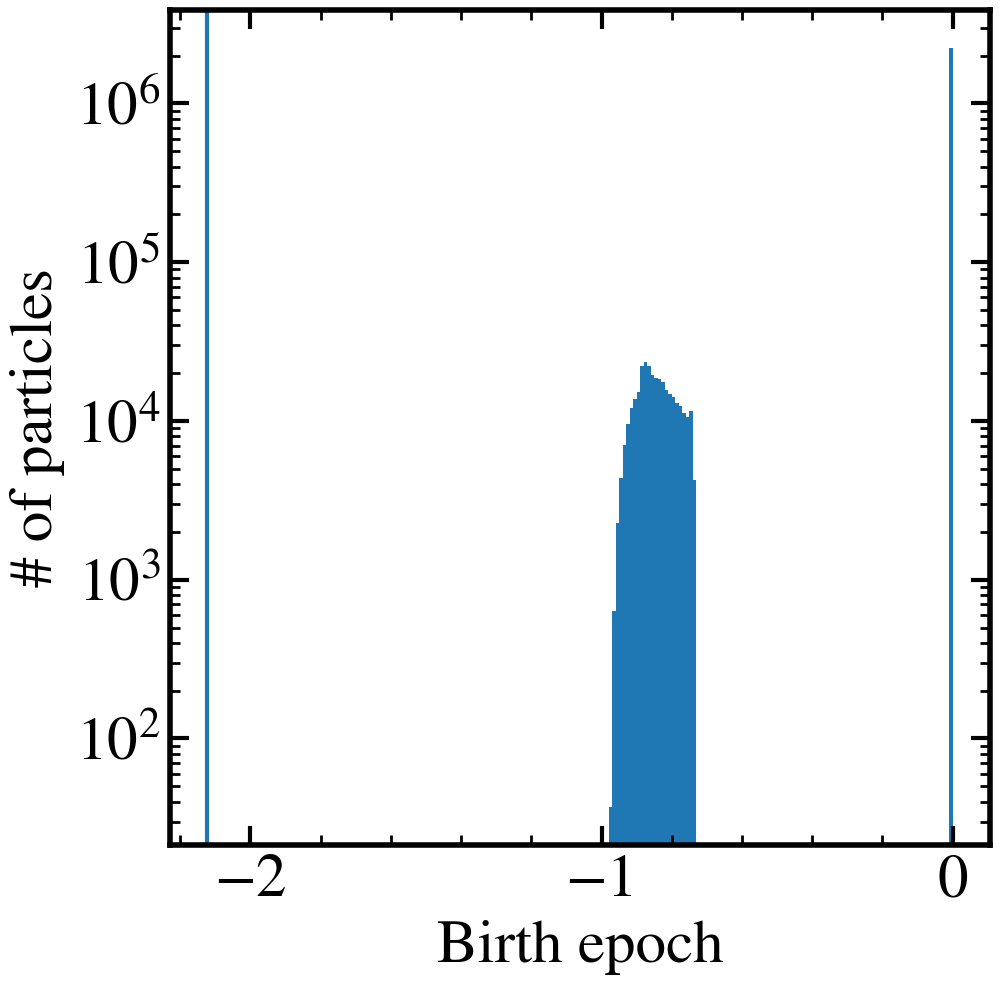

Text(0, 0.5, '# of particles')

In [26]:
plt.subplots(figsize=(5, 5))
plt.hist(tp_birth, bins=np.linspace(-1, 0, 101))
plt.axvline(info['time'])
plt.yscale('log')
plt.subplots_adjust(bottom=0.155, left=0.17, top=0.99, right=0.99)
plt.xlabel("Birth epoch")
plt.ylabel("# of particles")

In [20]:
# import pandas as pd

# pd.read_csv("table_cpl-1.0+0.0.csv")

Unnamed: 0        t       tau        a      t_Gyr
0              0  0.00000  0.000000  1.00000   0.000000
1              1 -0.00011 -0.000111  0.99989  -0.001495
2              2 -0.00022 -0.000223  0.99978  -0.002990
3              3 -0.00033 -0.000334  0.99967  -0.004485
4              4 -0.00044 -0.000446  0.99956  -0.005980
...          ...      ...       ...      ...        ...
9995        9995 -1.09956       NaN      NaN -14.942971
9996        9996 -1.09967       NaN      NaN -14.944466
9997        9997 -1.09978       NaN      NaN -14.945961
9998        9998 -1.09989       NaN      NaN -14.947456
9999        9999 -1.10000       NaN      NaN -14.948951

[10000 rows x 5 columns]